In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import gc
import configs

from data.ValidationDataset import NoisyDataset

# Parameters

In [45]:
netname = 'pnet'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
activations_dir = f'{engram_dir}3_activations/{netname}/'
pca_activations_dir = f'{engram_dir}4_activations_pca/{netname}/'
pickles_dir = f'{engram_dir}pickles/'
bg_types = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snr_types = [-9.0, -6.0, -3.0, 0.0, 3.0]

# Helper Functions

In [12]:
def get_gini(var_ratio):
    total = 0
    for i, xi in enumerate(var_ratio[:-1], 1):
        total += np.sum(np.abs(xi - var_ratio[i:]))
    return total / (len(var_ratio)**2 * np.mean(var_ratio))

In [13]:
def get_auc(var_ratio):
    var_curve = np.cumsum(var_ratio)
    var_auc = np.trapz(var_curve, dx=1/var_curve.size)
    return var_auc

In [14]:
def get_entro(var_ratio):
    var_entro = -np.sum(var_ratio * np.log(var_ratio)) / np.log(2)
    return var_entro

In [15]:
def get_n_components(var_ratio):
    var_curve = np.cumsum(var_ratio)
    return np.argwhere(var_curve > 0.9)[0].item()

# Load PCA models

In [18]:
pfile_path = f'{pickles_dir}{netname}_dimensionality.p'

if os.path.exists(pfile_path):
    with open(f'{pickles_dir}{netname}_dimensionality.p', 'rb') as f:
        df = pickle.load(f)
else:
    bgs = []
    snrs = []
    convs = []
    ts = []
    auc = []
    gini_coeff = []
    entro = []
    n_comps = []
    for bg in bg_types:
        for snr in snr_types:
            for conv_idx in [1,2,3,4,5]:
                for t in [0,1,2,3,4]:
                    bgs.append(bg)
                    snrs.append(snr)
                    convs.append(conv_idx)
                    ts.append(t)

                    pca_path = f'{pca_activations_dir}PCA_{bg}_{snr}_conv{conv_idx}_t{t}.p'
                    with open(pca_path, 'rb') as f:
                        pca = pickle.load(f)
                    var_ratio = pca.explained_variance_ratio_
                    auc.append(get_auc(var_ratio))
                    gini_coeff.append(get_gini(var_ratio))
                    entro.append(get_entro(var_ratio))
                    n_comps.append(get_n_components(var_ratio))

    df = pd.DataFrame({
        'BG': bgs,
        'SNR': snrs,
        'Layer': convs,
        'Timestep': ts,
        'AUC': auc,
        'Gini Coefficient': gini_coeff,
        'Entropy': entro,
        'N Components': n_comps
        })

    with open(f'{pickles_dir}{netname}_dimensionality.p', 'wb') as f:
        pickle.dump(df, f)

Text(0.5, 1.0, 'Clean')

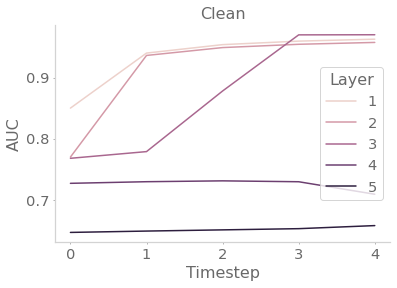

In [31]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timestep', y='AUC', hue='Layer',
    data=df[df['BG']=='None'],
    ax=ax)
ax.set_title(f'Clean')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


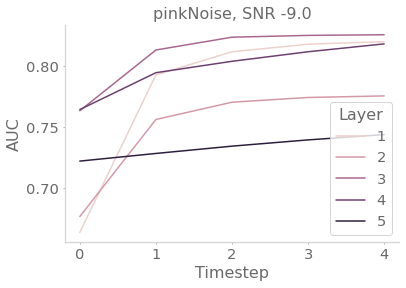

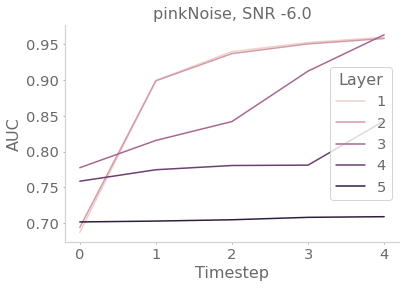

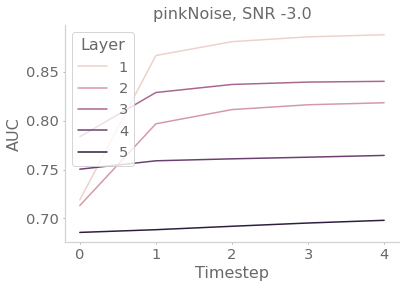

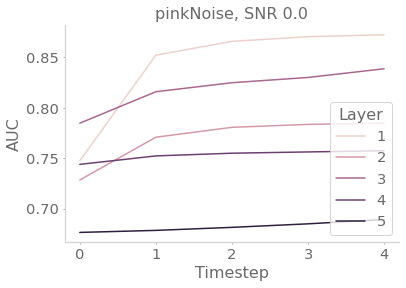

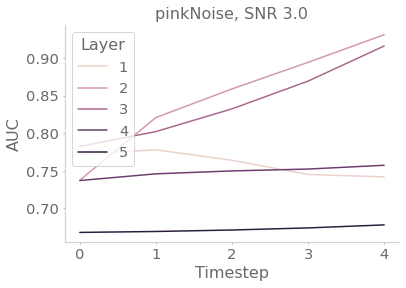

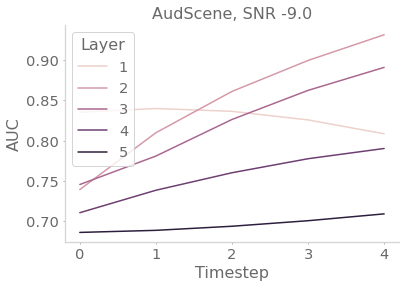

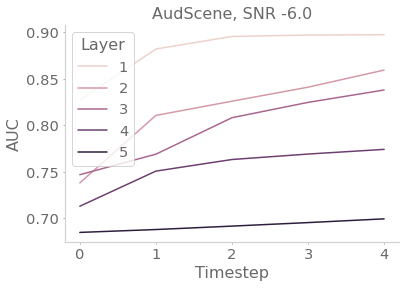

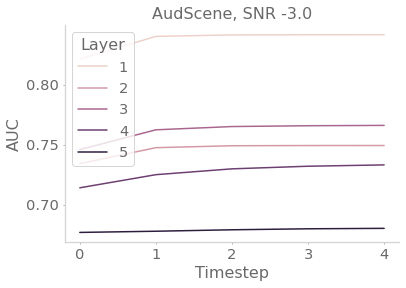

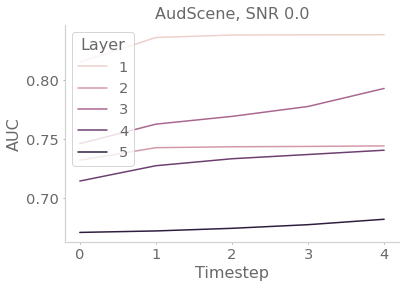

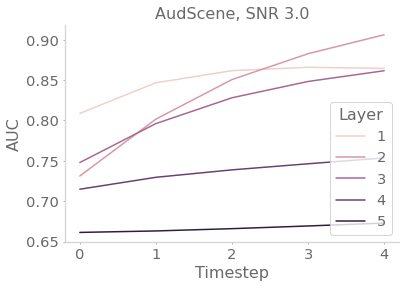

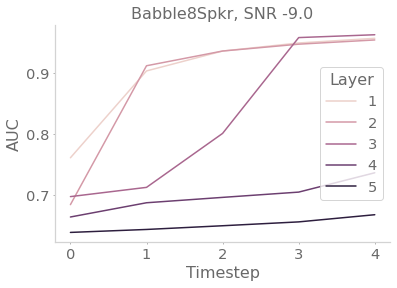

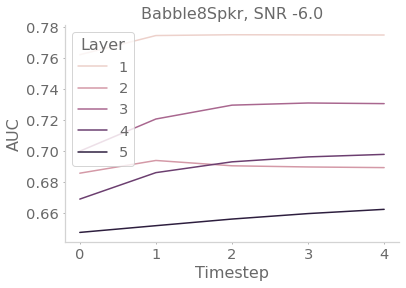

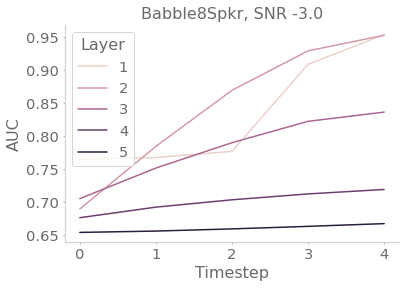

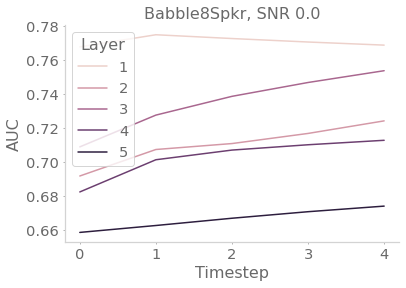

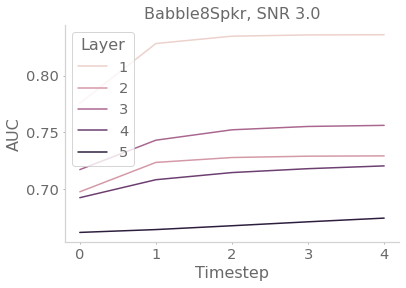

In [22]:
for bg in bg_types:
    for snr in snr_types:
        fig, ax = plt.subplots()
        sns.lineplot(
            x='Timestep', y='AUC', hue='Layer',
            data=df[(df['BG']==bg) & (df['SNR']==snr)],
            ax=ax)
        ax.set_title(f'{bg}, SNR {snr}')

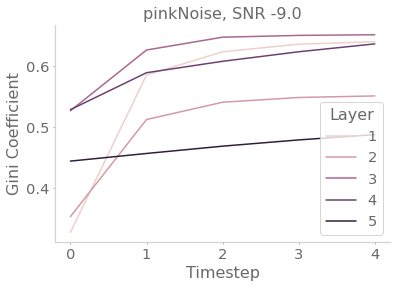

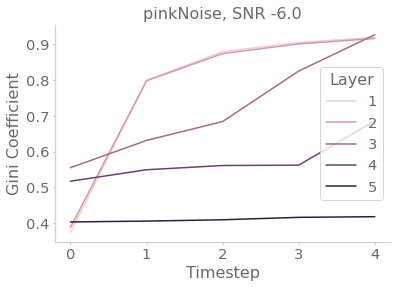

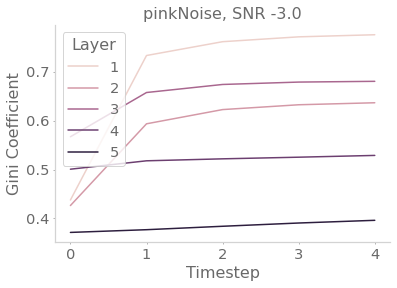

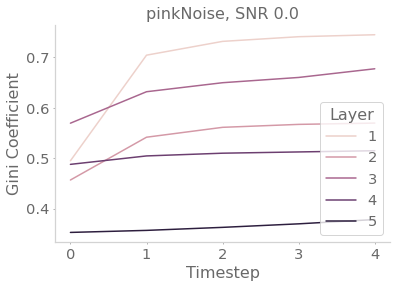

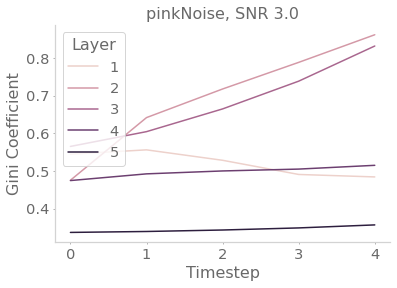

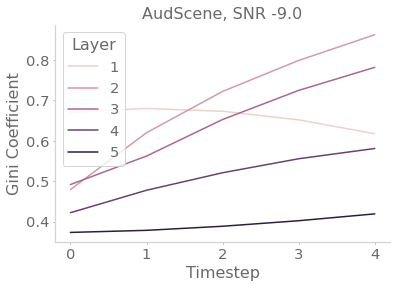

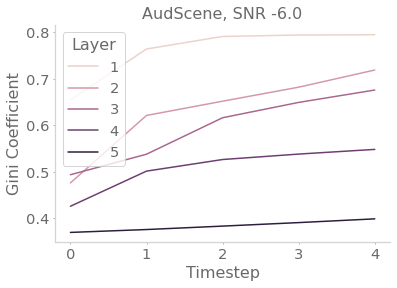

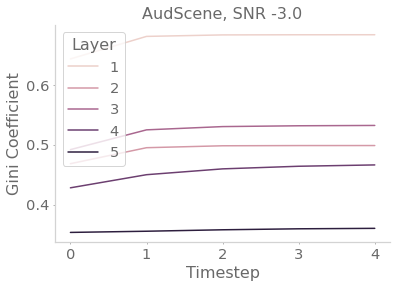

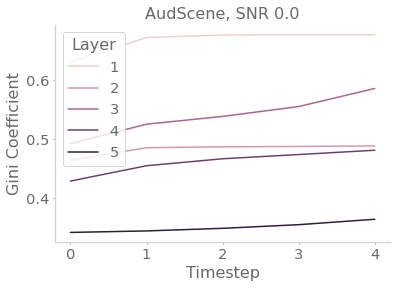

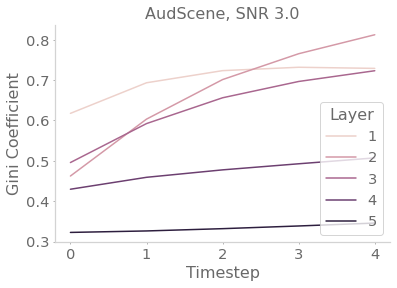

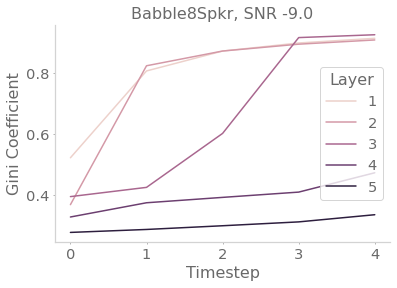

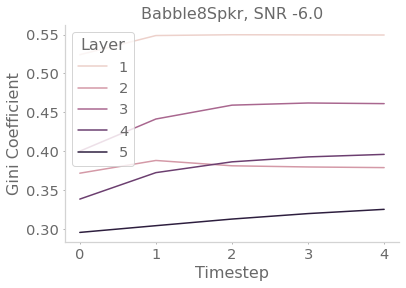

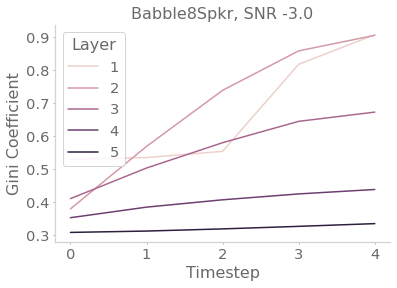

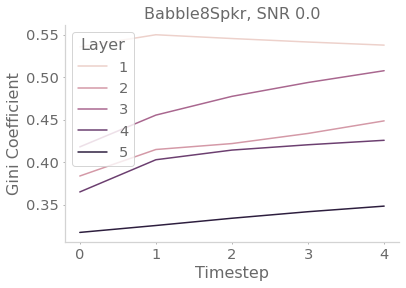

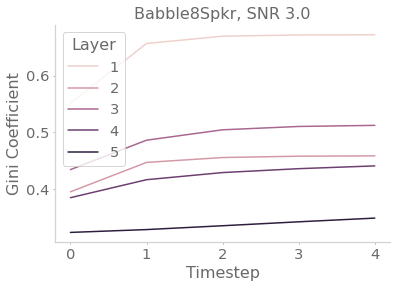

In [23]:
for bg in bg_types:
    for snr in snr_types:
        fig, ax = plt.subplots()
        sns.lineplot(
            x='Timestep', y='Gini Coefficient', hue='Layer',
            data=df[(df['BG']==bg) & (df['SNR']==snr)],
            ax=ax)
        ax.set_title(f'{bg}, SNR {snr}')

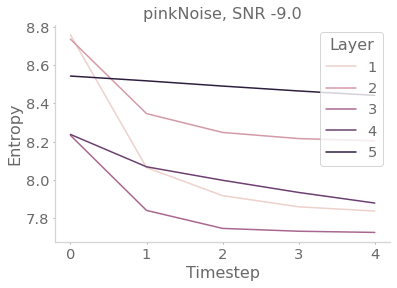

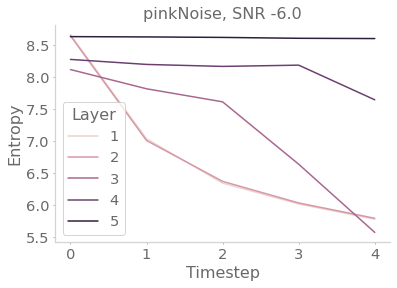

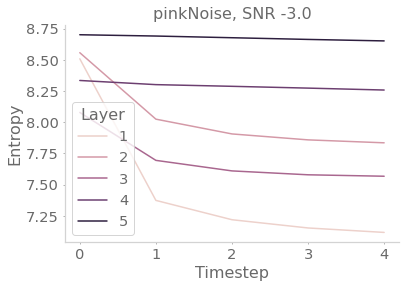

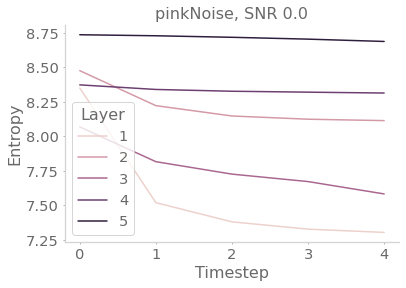

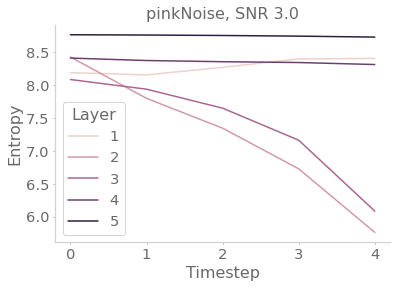

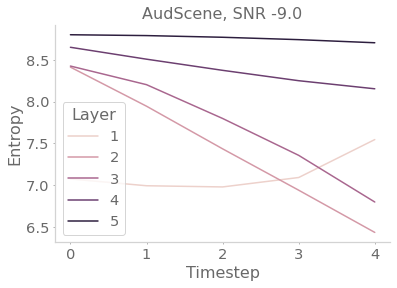

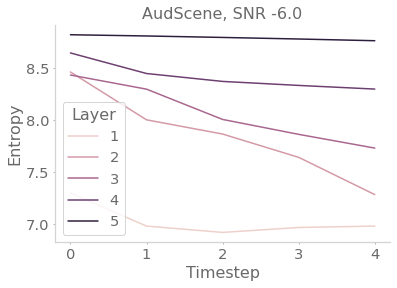

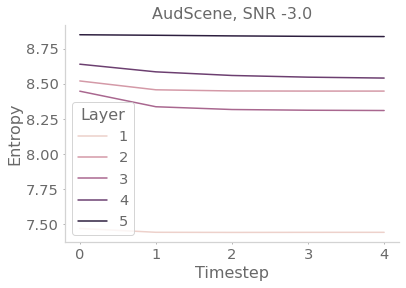

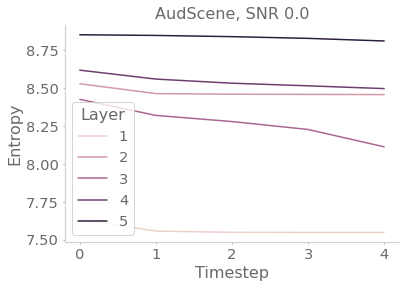

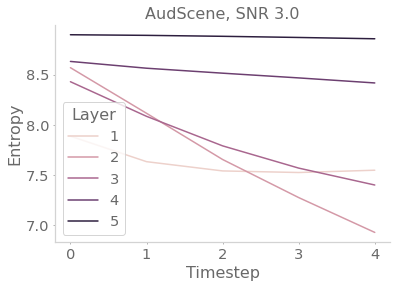

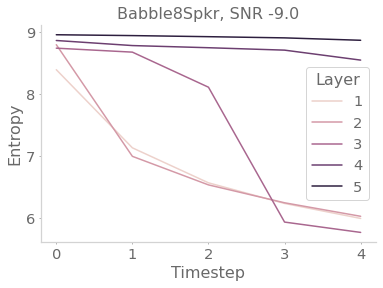

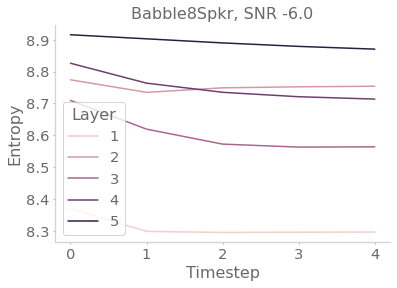

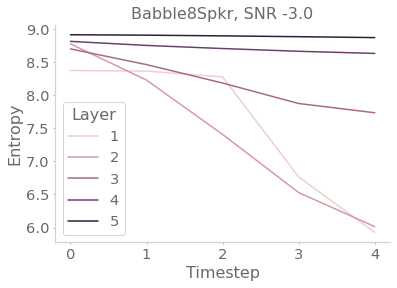

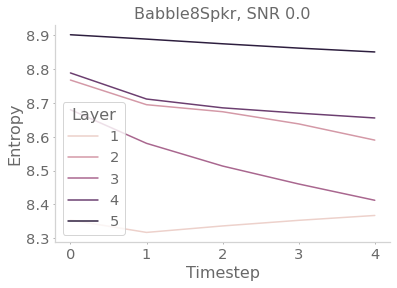

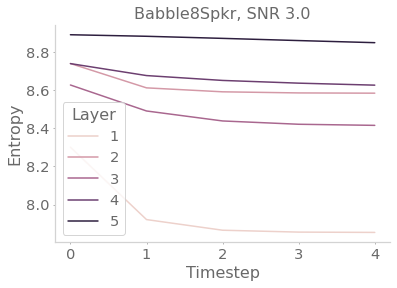

In [24]:
for bg in bg_types:
    for snr in snr_types:
        fig, ax = plt.subplots()
        sns.lineplot(
            x='Timestep', y='Entropy', hue='Layer',
            data=df[(df['BG']==bg) & (df['SNR']==snr)],
            ax=ax)
        ax.set_title(f'{bg}, SNR {snr}')

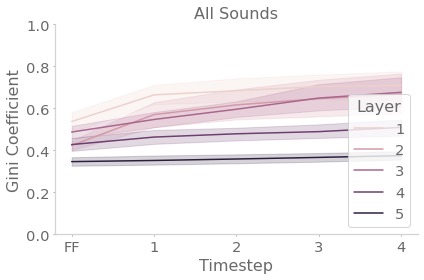

In [42]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timestep', y='Gini Coefficient', hue='Layer',
    data=df[df['BG'] != 'None'], ax=ax)
ax.set_title(f'All Sounds')
ax.set_ylim(0, 1)
ax.set_xticks([0,1,2,3,4], ['FF',1,2,3,4])
plt.tight_layout()
plt.savefig('dimensionality.png', dpi=300)

(0.0, 1.0)

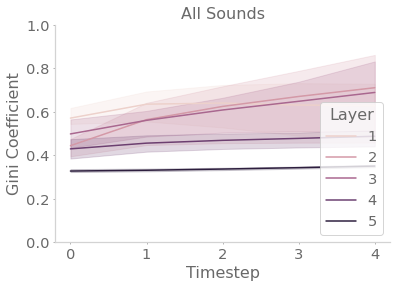

In [39]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timestep', y='Gini Coefficient', hue='Layer',
    data=df[df['SNR'] == 3.0], ax=ax)
ax.set_title(f'All Sounds')
ax.set_ylim(0, 1)

(0.5, 1.0)

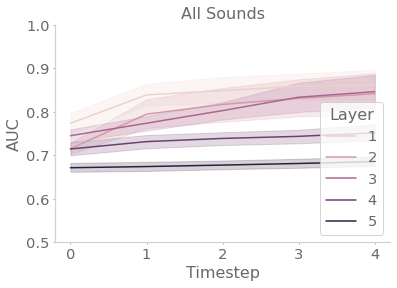

In [36]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timestep', y='AUC', hue='Layer',
    data=df, ax=ax)
ax.set_title(f'All Sounds')
ax.set_ylim(0.5, 1)

Text(0.5, 1.0, 'All Sounds')

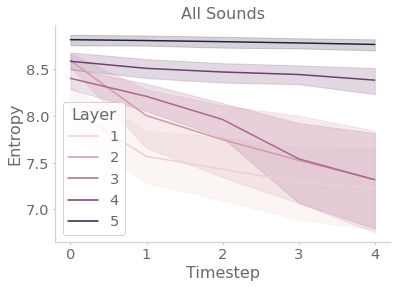

In [37]:
fig, ax = plt.subplots()
sns.lineplot(
    x='Timestep', y='Entropy', hue='Layer',
    data=df, ax=ax)
ax.set_title(f'All Sounds')